# Image Preprocessing

As part of the image preprocessing, we will have to paste the stamp image over the images that we crawled.

Since we are synthesising the images, we get the following advantage:
- We can easily get a set of images with and without the stamp (pasted vs original)
- We know the coordinates where these images are pasted which is necessary for image localisation

### What we do in pre processing

In preprocessing, we do the following:
    - Paste the stamp image on top of the crawled images in some random location and save it in OUTPUT_DIR_PATH
    - Generate a CSV that contains file names, a boolean if it has stamp or not, and its XY coordinates

Import necessary libraries

In [2]:
from pathlib import Path
from PIL import ImageDraw, ImageFont , Image
from matplotlib import patches,patheffects
import matplotlib.pyplot as plt
import uuid
from random import randint

We set paths of all the directories we are using...

In [3]:
PATH= Path('./data/stamp-localisation')
OUTPUT_DIR_PATH= Path('./data/stamp-localisation/stamped')
BING_WORK_PATH=Path('./data/stamp-localisation/bing')
GOOGLE_WORK_PATH=Path('./data/stamp-localisation/google')
# BING_GROCERY_WORK_PATH=Path('./data/stamp-localisation/bing-grocery')
# GOOGLE_GROCERY_WORK_PATH=Path('./data/stamp-localisation/google-grocery')
STAMP_IMAGE_PATH=Path('./data/stamp-localisation/stamp-image.png')
CSV_PATH=Path(PATH/'stamped.csv')

After providing the locations, we just run once and check if all the locations are imported correctly

In [3]:
list(BING_WORK_PATH.iterdir())[:5]

[PosixPath('data/stamp-localisation/bing/000374.jpg'),
 PosixPath('data/stamp-localisation/bing/000169.jpg'),
 PosixPath('data/stamp-localisation/bing/000510.jpg'),
 PosixPath('data/stamp-localisation/bing/000432.jpg'),
 PosixPath('data/stamp-localisation/bing/000289.jpg')]

In [4]:
STAMP_IMAGE_PATH.exists()

True

From time to time, while developing, we may run into the issues, so we may have to delete the folder and the CSV file contains the generated image and its information before regeneration. If the folder is of smaller size, I prefer to delete using notebook. But if we are running for huge image, I prefer to run it in the actual shell than in notebook cell as notebook hangs.

In [19]:
!rm -rf {OUTPUT_DIR_PATH}/*
!rm {CSV_PATH}

### Generate Training/Test Data

#### Training file creation

The training output file is the CSV file that has the following details. 
- The File name of the image
- A boolean if the image contains the stamp or not
- The x and y coordinates of the top-left and bottom-right corner of the image (totally 4 values)

### To generate image with the stamp in *save_synthesised_img*

We under go the following steps:
- First we take the art work image, and stamp image
- Check if stamp image can fit in to art work image
    - Else shrink the image to smaller size so that the stamp can fit inside the art work
- Choose a random coordinates of the art work image, where we can paste the stamp image.
<br/>*Here, we have the range of 0 to (total height of art work - stamp height) as the range, since if the stamp is beyond it, the stamp might get truncated from the art work image, which is not what we want.*
- Save the coordinates where the stamp image is available to the file
- Save the superimposed art work in the output directory

It is to be noted that we have used *PIL* library to do so

In [21]:
def save_synthesised_img(thefile,art_work_image,stamp_image):
    (a_width,a_height)=art_work_image.size
    (n_width,n_height)=stamp_image.size
#     angle = randint(0,360)
#     stamp_image=stamp_image.rotate(angle,expand=1)
    is_resized=False
    if(n_height > a_height):
            (n_width,n_height)=(int(n_width*a_height/n_height),a_height)
            is_resized=True
    if(n_width > a_width):
            (n_width,n_height)=(a_width,(int(n_height*a_width/n_width)))
            is_resized=True
    if(is_resized):
        stamp_image= stamp_image.resize((n_width,n_height))
    coord_h1 =  randint(0,a_height-n_height)
    coord_w1 =  randint(0,a_width-n_width)
    art_work_img1=art_work_image.copy()
    art_work_img1.paste(stamp_image,(coord_w1,coord_h1),stamp_image)
    coors = '{} {} {} {}'.format(coord_w1,coord_h1,n_width+coord_w1,n_height+coord_h1)
    fn1=str(uuid.uuid4())+'.jpeg'
    thefile.write(fn1+',1,'+coors+'\n')
    art_work_img1.save(str(OUTPUT_DIR_PATH/fn1))

We have the *gen_image* method which des the following:
- Save the original artwork and reference in CSV file saying that there is no stamp with coordinate as (0,0,0,0)
- Generate 2 images with the same art work background with the stamp over it on 2 different locations

In [24]:
def gen_image(thefile,art_work_path,stamp_image):
    labels =[]
    coord_w, coord_h = (0,0)
    art_work_image = Image.open(art_work_path).convert('RGB')
    fn_nolabel1=str(uuid.uuid4())+'.jpeg'
    art_work_image.save(OUTPUT_DIR_PATH/str(fn_nolabel1))
    thefile.write(fn_nolabel1+',0,0 0 0 0\n')
    for i in range(0,2):
        save_synthesised_img(thefile,art_work_image,stamp_image)

Here, we generate a file called *generated.csv* and run a for loop across all the images that we have downloaded. Thus, we are generating overall 3$*$(google images+bing images) images generated along with the file.

This cell runs a while and generate around 6000 images.

In [25]:
labels=[]
thefile = open(CSV_PATH, 'a')
stamp_image = Image.open(STAMP_IMAGE_PATH).convert('RGBA').resize((220,220))
for art_work_image in GOOGLE_WORK_PATH.iterdir():
    labels = gen_image(thefile,art_work_image,stamp_image)
for art_work_image in BING_WORK_PATH.iterdir():
    labels = gen_image(thefile,art_work_image,stamp_image)

/home/controller/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [18]:
for art_work_image in GOOGLE_GROCERY_WORK_PATH.iterdir():
    labels = gen_image(thefile,art_work_image)
for art_work_image in BING_GROCERY_WORK_PATH.iterdir():
    labels = gen_image(thefile,art_work_image)

/home/controller/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/controller/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Now that we ran the cells, we can look at few sample generated images to know how it come out.

(1181, 784)


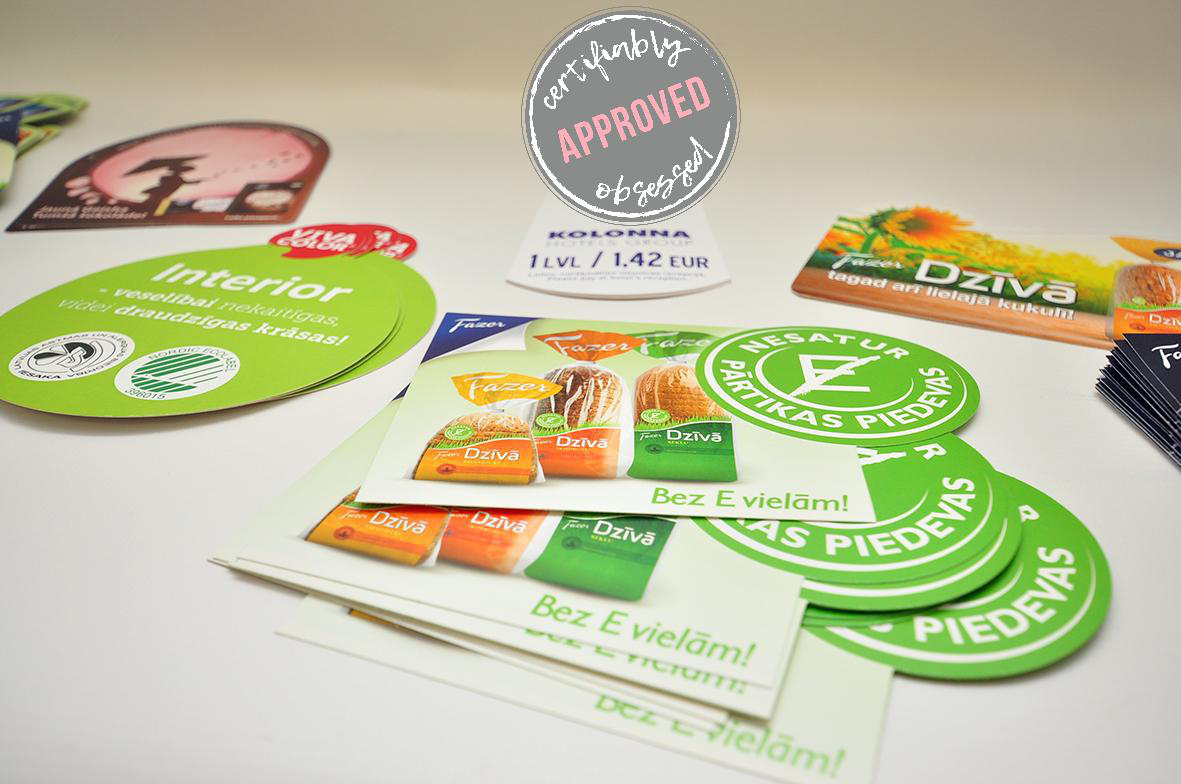

In [4]:
items = list(OUTPUT_DIR_PATH.iterdir())
sample_image = Image.open(items[321])
print(sample_image.size)
sample_image

By changing the array index, I was able to find out the list of coordinates for those images. Now lets check if we were extracting the coordinates correctly or not.

We do the following:
- Open the file and take a row from it and seperate by comma
- We know that the first value in the CSV is the file name, so we take that
- The last part of the CSV is the bounding box coordinates. We take that as well
- Split the bounding box by space, convert it to integer and grab the coordinates
- If the bounding box is valid, we crop and display the output. Else, we just display the image.

Simple enough, we see that the bounding box was calculated accurately.

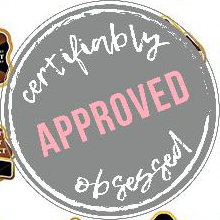

In [7]:
values=CSV_PATH.open().readlines()[3212].split(',')
fn = values[0]
coord = values[2]
coord_x1,coord_y1,coord_x2,coord_y2 =  map(int,coord.split(' '))
sample_image = Image.open(OUTPUT_DIR_PATH/fn)
if(int(values[1])==1):
    sample_image= sample_image.crop((coord_x1,coord_y1,coord_x2,coord_y2))
sample_image

We have prepared the data well enough. Now, we have to run train our model